## Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.


In [1]:
# import all required libraries
import numpy as np
import cv2
import glob
import math
import time
import itertools
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from multi_plot import *
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
import scipy.ndimage as snd
# NOTE: the next import is only valid for scikit-learn version <= 0.17
#from sklearn.cross_validation import train_test_split
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split

%matplotlib inline

Number of car files:  8792
Number of non-car files:  8968


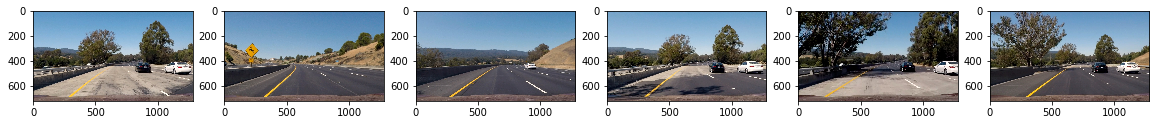

In [18]:
test_files = glob.glob('./test_images/*.jpg')
car_files = glob.glob('vehicles/**/*.png', recursive=True)
print("Number of car files: ", len(car_files))
notcar_files = glob.glob('non_vehicles/**/*.png', recursive=True)
print("Number of non-car files: ", len(notcar_files))
output_folder = './output_images/'

test_images = []
for fname in test_files:
    img = snd.imread(fname)
    test_images.append(img)
    
plot_images(test_images, n_cols=6)

[]

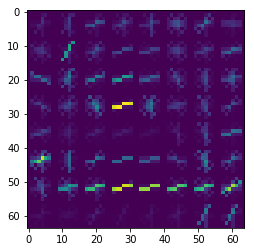

In [29]:
%run feature_extraction.py
example_cars = [snd.imread(file)[:,:,1] for file in car_files[0:2]]
example_notcars = [snd.imread(file) for file in notcar_files[0:2]]
hog_
for img in test_cars:
    hog_features, hog_img = get_hog_features(hog, orient=9, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=True)

plt.imshow(hog_img)
plt.plot()

In [17]:
%run feature_extraction.py
# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
sample_size = 2000
cars = car_files[0:sample_size]
notcars = notcar_files[0:sample_size]

### TODO: Tweak these parameters and see how the results change.
color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [300, 780] # Min and max in y to search in slide_window()

def train_svc():
    car_features = extract_features(cars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = extract_features(notcars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    print(len(car_features[0]))
    X = np.vstack((car_features, notcar_features)).astype(np.float32) 
    print(X.shape)
    print(X[0])
    plt.plot(X[1])
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

    print('Using:',orient,'orientations',pix_per_cell, 'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t=time.time()
    return svc, X_scaler

svc, X_scaler = train_svc()

5292


MemoryError: 

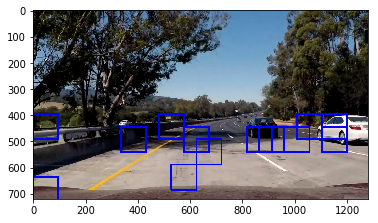

In [15]:
%run feature_extraction.py
image = snd.imread(test_files[4])
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)